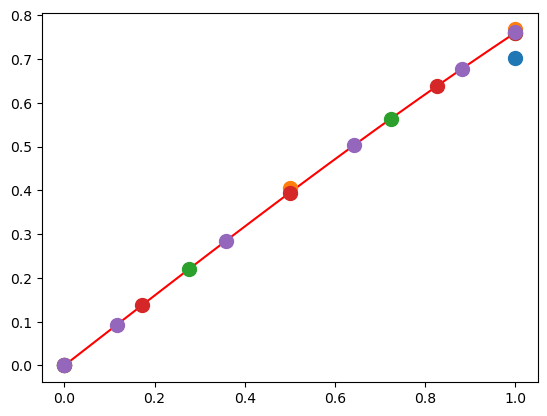

In [2]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# final time
tf = 1.0

# solve with ODEINT (for comparison)
def model(x,t):
    u = 4.0
    return (-x**2 + u)/5.0
t = np.linspace(0,tf,20)
y0 = 0
y = odeint(model,y0,t)
plt.figure(1)
plt.plot(t,y,'r-',label='ODEINT')

# ----------------------------------------------------
# Approach #1 - Write the model equations in Python
# ----------------------------------------------------
# define collocation matrices
def colloc(n):
    if (n==2):
        NC = np.array([[1.0]])
    if (n==3):
        NC = np.array([[0.75,-0.25], \
                       [1.00, 0.00]])
    if (n==4):
        NC = np.array([[0.436,-0.281, 0.121], \
                       [0.614, 0.064, 0.0461], \
                       [0.603, 0.230, 0.167]])
    if (n==5):
        NC = np.array([[0.278, -0.202, 0.169, -0.071], \
                       [0.398,  0.069, 0.064, -0.031], \
                       [0.387,  0.234, 0.278, -0.071], \
                       [0.389,  0.222, 0.389,  0.000]])
    if (n==6):
        NC = np.array([[0.191, -0.147, 0.139, -0.113, 0.047],
                       [0.276,  0.059, 0.051, -0.050, 0.022],
                       [0.267,  0.193, 0.252, -0.114, 0.045],
                       [0.269,  0.178, 0.384,  0.032, 0.019],
                       [0.269,  0.181, 0.374,  0.110, 0.067]])
    return NC

# define collocation points from Lobatto quadrature
def tc(n):
    if (n==2):
        time = np.array([0.0,1.0])
    if (n==3):
        time = np.array([0.0,0.5,1.0])
    if (n==4):
        time = np.array([0.0, \
                         0.5-np.sqrt(5)/10.0, \
                         0.5+np.sqrt(5)/10.0, \
                         1.0])
    if (n==5):
        time = np.array([0.0,0.5-np.sqrt(21)/14.0, \
                         0.5,0.5+np.sqrt(21)/14.0, 1])
    if (n==6):
        time = np.array([0.0, \
                         0.5-np.sqrt((7.0+2.0*np.sqrt(7.0))/21.0)/2.0, \
                         0.5-np.sqrt((7.0-2.0*np.sqrt(7.0))/21.0)/2.0, \
                         0.5+np.sqrt((7.0-2.0*np.sqrt(7.0))/21.0)/2.0, \
                         0.5+np.sqrt((7.0+2.0*np.sqrt(7.0))/21.0)/2.0, \
                         1.0])
    return time*tf

# solve with SciPy fsolve
def myFunction(z,*param):
    n = param[0]
    m = param[1]
    # rename z as x and xdot variables
    x = np.empty(n-1)
    xdot = np.empty(n-1)
    x[0:n-1] = z[0:n-1]
    xdot[0:n-1] = z[n-1:m]

    # initial condition (x0)
    x0 = 0.0
    # input parameter (u)
    u = 4.0
    # final time
    tn = tf

    # function evaluation residuals
    F = np.empty(m)
    # nonlinear differential equations at each node
    # 5 dx/dt = -x^2 + u
    F[0:n-1] = 5.0 * xdot[0:n-1] + x[0:n-1]**2 - u
    # collocation equations
    # tn * NC * xdot = x - x0
    NC = colloc(n)
    F[n-1:m] = tn * np.dot(NC,xdot) - x + x0 * np.ones(n-1)
    return F

sol_py = np.empty(5) # store 5 results
for i in range(2,7):
    n = i
    m = (i-1)*2
    zGuess = np.ones(m)
    z = fsolve(myFunction,zGuess,args=(n,m))
    # add to plot
    yc = np.insert(z[0:n-1],0,0)
    plt.plot(tc(n),yc,'o',markersize=10)
    # store just the last x[n] value
    sol_py[i-2] = z[n-2]

In [3]:
from scipy.integrate import odeint
import numpy as np


def collocation(x,t):
    u = 4
    xdot = -x**2 / 5.0 + u / 5.0

    return xdot
  
y3 = odeint(collocation,[0],[0, 0.5, 1])

print('ODEINT solution')
print('x1 = ' + str(y3[1]))
print('x2 = ' + str(y3[2]))
print(' ')

ODEINT solution
x1 = [0.3947507]
x2 = [0.75989797]
 


In [4]:
pip install gekko

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 5.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


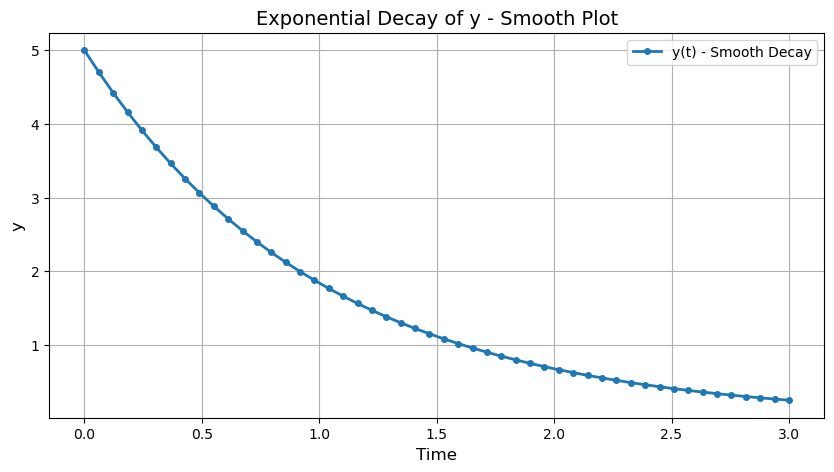

In [8]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Create a GEKKO model
m = GEKKO(remote=False)

# Create a GEKKO variable with initial condition
y = m.Var(5.0, name='y')

# Create a GEKKO equation defining the dynamic behavior
m.Equation(y.dt() == -y)

# Define a denser set of time points for the output of the solution
m.time = np.linspace(0, 3, 50)  # Use linspace to create 50 time points between 0 and 3

# Set simulation mode
m.options.IMODE = 4

# Set number of nodes for each time interval to increase the interpolation detail
m.options.NODES = 6

# Solve the model without displaying solver output
m.solve(disp=False)

# Plotting the results
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(m.time, y.value, 'o-', label='y(t) - Smooth Decay', linewidth=2, markersize=4)  # Plot y values vs. time

# Adding labels and legend
plt.xlabel('Time', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Exponential Decay of y - Smooth Plot', fontsize=14)
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()


In [10]:
m = GEKKO(remote=False)
# Define the state variables
y = m.Var(value=1.0)  # Initial condition for y
z = m.Var(value=0)    # y' = z, so initial condition for z is dy/dt at t=0
mu = 2                # Parameter that affects nonlinearity

# Van der Pol's Equation
m.Equation(y.dt() == z)
m.Equation(z.dt() == mu*(1 - y**2)*z - y)

# Time points
m.time = np.linspace(0, 20, 101)

# Solve
m.options.IMODE = 4  # dynamic simulation
m.solve(disp=False)

# Plot results
plt.figure()
plt.plot(m.time, y.value, label='y(t)')
plt.plot(m.time, z.value, label='z(t)')
plt.xlabel('Time')
plt.ylabel('Response')
plt.legend()
plt.show()


Exception: @error: Solution Not Found


In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

def true_ode_func(t, u):
    true_A = np.array([[-0.1, 2.0], [-2.0, -0.1]])
    return (u ** 3).dot(true_A.T)

def solve_ode(func, u0, t_span, t_eval):
    sol = solve_ivp(func, t_span, u0, t_eval=t_eval)
    return sol.y

# Generate data
u0 = np.array([2.0, 0.0])
t_span = (0.0, 1.5)
t_eval = np.linspace(t_span[0], t_span[1], 30)
ode_data = solve_ode(true_ode_func, u0, t_span, t_eval)

# Define a neural network for the ODE (using a simple linear approximation here for illustration)
def neural_ode(t, u, p):
    W1 = p[:50].reshape((2, 25))
    W2 = p[50:].reshape((25, 2))
    return np.tanh(u @ W1) @ W2

# Define the cost function
def cost_function(p):
    pred = np.array([neural_ode(t, ode_data[:, i], p) for i, t in enumerate(t_eval)])
    loss = np.sum((ode_data - pred.T) ** 2)
    return loss

# Optimize the parameters
initial_params = np.random.randn(2 * 25 + 25 * 2)  # Random initial parameters
result = minimize(cost_function, initial_params, method='L-BFGS-B')

print('Optimized parameters:', result.x)


Optimized parameters: [ 0.48375538  0.67489889  0.24397197  0.48098958 -1.4812513  -0.54654169
 -0.75389534 -0.35276172  1.28205582 -0.66123279  1.39813533  0.46448561
 -0.07092697 -0.13411355 -1.84278469  0.29026529  1.62348054  1.77166829
  1.69975232 -0.29119954  0.43783636  0.28838626  1.55955294 -0.03546182
 -0.13003134  0.07656462 -0.97422416 -1.6322282  -1.2588878   1.15093504
  1.18702827  0.68371439 -0.28469283 -0.5960496  -2.17526415 -1.20476973
 -1.88640869  1.16222766 -0.44418137 -1.08372616 -0.87552871 -0.22266876
 -0.125821    0.04487001  0.16544246 -0.92576042 -1.16105531 -0.0994083
  0.38096735 -1.45119022  1.74270115  1.75041212  0.61766229 -0.91906492
 -0.79724064  0.6271838  -0.62774781 -0.5414016   0.01739242  1.74505756
  1.07813577 -1.3576312  -0.22495681 -0.04310802 -0.37138113 -0.35348291
  0.09264783  0.94111883  0.16262615  0.30398267 -0.27646255  1.71380415
  0.37194846  0.19823383 -1.40846634  0.04136233 -0.38016428 -0.75821517
  0.11668326  0.15228977 -2.19

/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_51399/3557089628.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(t_eval, predictions[0, :], 'r--', label='Predicted (u1)', color = 'green')
/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_51399/3557089628.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(t_eval, predictions[1, :], 'b--', label='Predicted (u2)', color = 'orange')


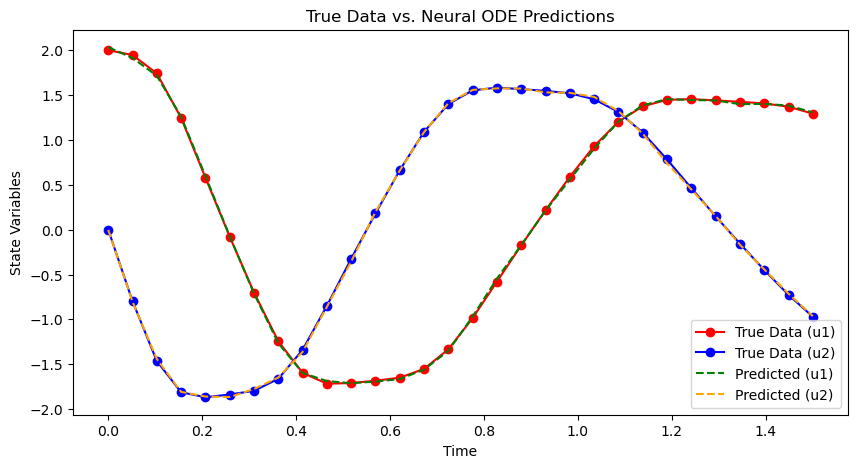

In [5]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the true ODE function
def true_ode_func(t, u):
    true_A = np.array([[-0.1, 2.0], [-2.0, -0.1]])
    return (u ** 3).dot(true_A.T)

# Solve the ODE to generate data
def solve_ode(func, u0, t_span, t_eval):
    sol = solve_ivp(func, t_span, u0, t_eval=t_eval)
    return sol.y

# Initial conditions and time points
u0 = np.array([2.0, 0.0])
t_span = (0.0, 1.5)
t_eval = np.linspace(t_span[0], t_span[1], 30)
ode_data = solve_ode(true_ode_func, u0, t_span, t_eval)

# Define the neural network for the ODE
def neural_ode(t, u, p):
    W1 = p[:50].reshape((2, 25))
    W2 = p[50:].reshape((25, 2))
    return np.tanh(u @ W1) @ W2

# Define the cost function
def cost_function(p):
    pred = np.array([neural_ode(t, ode_data[:, i], p) for i, t in enumerate(t_eval)])
    loss = np.sum((ode_data - pred.T) ** 2)
    return loss

# Optimize the parameters
initial_params = np.random.randn(2 * 25 + 25 * 2)  # Random initial parameters
result = minimize(cost_function, initial_params, method='L-BFGS-B')

# Generate predictions using the optimized parameters
optimized_params = result.x
predictions = np.array([neural_ode(t, ode_data[:, i], optimized_params) for i, t in enumerate(t_eval)]).T

# Plot the true data and predictions
plt.figure(figsize=(10, 5))
plt.plot(t_eval, ode_data[0, :], 'ro-', label='True Data (u1)')
plt.plot(t_eval, ode_data[1, :], 'bo-', label='True Data (u2)')
plt.plot(t_eval, predictions[0, :], 'r--', label='Predicted (u1)', color = 'green')
plt.plot(t_eval, predictions[1, :], 'b--', label='Predicted (u2)', color = 'orange')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.title('True Data vs. Neural ODE Predictions')
plt.show()


In [11]:
pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 4.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 6.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


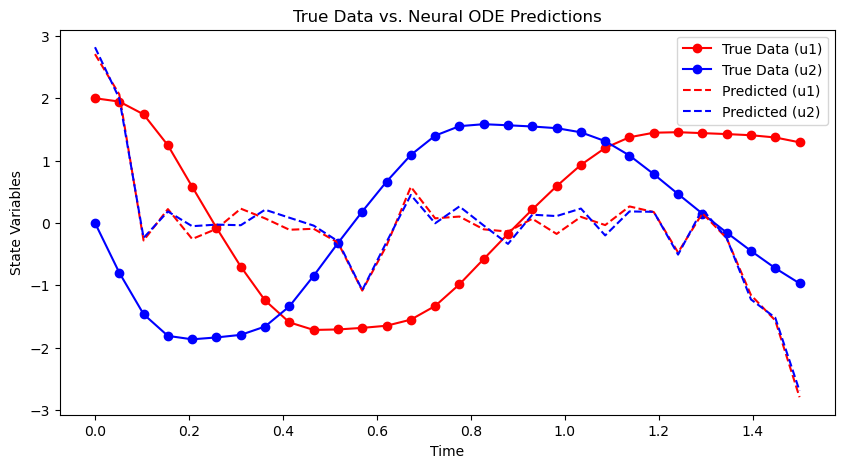

In [12]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

def true_ode_func(t, u):
    true_A = np.array([[-0.1, 2.0], [-2.0, -0.1]])
    return (u ** 3).dot(true_A.T)

def solve_ode(func, u0, t_span, t_eval):
    sol = solve_ivp(func, t_span, u0, t_eval=t_eval)
    return sol.y

u0 = np.array([2.0, 0.0])
t_span = (0.0, 1.5)
t_eval = np.linspace(t_span[0], t_span[1], 30)
ode_data = solve_ode(true_ode_func, u0, t_span, t_eval)

def smooth_and_derivative(data, t_eval, bandwidth=0.1):
    # Kernel smoothing to estimate the trajectory
    kde = KernelDensity(kernel='epanechnikov', bandwidth=bandwidth)
    kde.fit(t_eval[:, np.newaxis])
    log_dens = kde.score_samples(t_eval[:, np.newaxis])
    smoothed_trajectory = np.exp(log_dens)
    
    # Numerical differentiation to estimate the derivative
    dt = t_eval[1] - t_eval[0]
    smoothed_derivative = np.gradient(smoothed_trajectory, dt)
    
    return smoothed_trajectory, smoothed_derivative

smoothed_trajectory, smoothed_derivative = smooth_and_derivative(ode_data.T, t_eval)

def neural_ode(t, u, p):
    W1 = p[:50].reshape((2, 25))
    W2 = p[50:].reshape((25, 2))
    return np.tanh(u @ W1) @ W2

def cost_function(p):
    pred = np.array([neural_ode(t, ode_data[:, i], p) for i, t in enumerate(t_eval)]).T
    loss = np.sum((smoothed_derivative - pred) ** 2)
    return loss

initial_params = np.random.randn(2 * 25 + 25 * 2)
result = minimize(cost_function, initial_params, method='L-BFGS-B')

optimized_params = result.x
predictions = np.array([neural_ode(t, ode_data[:, i], optimized_params) for i, t in enumerate(t_eval)]).T

plt.figure(figsize=(10, 5))
plt.plot(t_eval, ode_data[0, :], 'ro-', label='True Data (u1)')
plt.plot(t_eval, ode_data[1, :], 'bo-', label='True Data (u2)')
plt.plot(t_eval, predictions[0, :], 'r--', label='Predicted (u1)')
plt.plot(t_eval, predictions[1, :], 'b--', label='Predicted (u2)')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.title('True Data vs. Neural ODE Predictions')
plt.show()


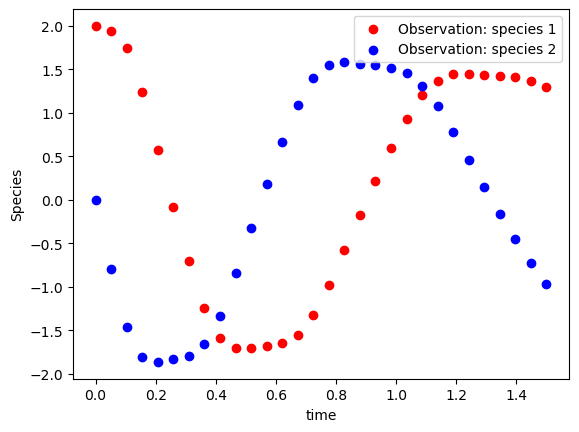

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the true ODE function
def true_ode_func(u, t):
    true_A = np.array([[-0.1, 2.0], [-2.0, -0.1]])
    du = np.dot(true_A, u**3)
    return du

# Initial conditions and time points
u0 = [2.0, 0.0]
t = np.linspace(0, 1.5, 30)

# Solve the ODE
ode_data = odeint(true_ode_func, u0, t)

# Plot the results
plt.figure()
plt.scatter(t, ode_data[:, 0], label="Observation: species 1", color='red')
plt.scatter(t, ode_data[:, 1], label="Observation: species 2", color='blue')
plt.xlabel("time")
plt.ylabel("Species")
plt.legend(loc='best')
plt.grid(False)
plt.show()
